# MLBootcamp  V

This code shows 7th place solution for competition of forecasting cardiovascular diseases (http://mlbootcamp.ru/round/12/sandbox/)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tqdm
import hyperopt
import sys
import scipy

import lightgbm
from catboost import CatBoost, CatBoostClassifier

from datetime import datetime
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import log_loss

/home/pershinmr/.virtualenvs/jafar/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Data can be obtained from competion page, or through [this link](http://mlbootcamp.ru/media/condition/ml5.zip)

In [2]:
train_df = pd.read_csv('train.csv', sep=';')
test_df = pd.read_csv('test.csv', sep=';', na_values='None')

##  Data exploration

In [3]:
print train_df.shape, test_df.shape

(70000, 13) (30000, 12)


In [4]:
full_df = pd.concat([train_df, test_df], axis=0)

#####  height fix

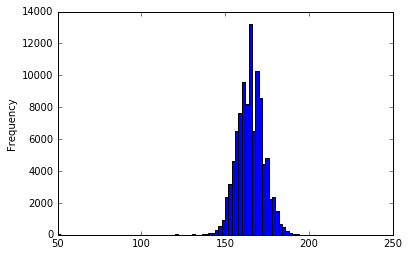

In [5]:
full_df.height.plot.hist(100)

In [6]:
full_df.loc[(full_df.height < 100), 'height'] += 100

#####  arterial pressure fix

In [7]:
full_df['ap_hi'] = full_df.ap_hi.abs()
full_df['ap_lo'] = full_df.ap_lo.abs()

In [8]:
np.percentile(full_df.ap_hi, [0.3, 99.9])

array([  80.,  215.])

In [9]:
np.percentile(full_df.ap_lo, [1, 98])

array([  60.,  110.])

In [10]:
while np.any(full_df.ap_hi > 800):
    full_df.loc[full_df.ap_hi > 800, 'ap_hi'] /= 10

In [11]:
for i in range(3):
    full_df.loc[full_df.ap_hi < 22, 'ap_hi'] *= 10

In [12]:
while np.any(full_df.ap_lo > 600):
    full_df.loc[full_df.ap_lo > 600, 'ap_lo'] /= 10

In [13]:
for i in range(3):
    full_df.loc[full_df.ap_lo < 11, 'ap_lo'] *= 10

##  Adding features

In [14]:
full_df.head()

,active,age,alco,ap_hi,ap_lo,cardio,cholesterol,gender,gluc,height,id,smoke,weight
0,1.0,18393,0.0,110.0,80.0,0.0,1,2,1,168,0,0.0,62.0
1,1.0,20228,0.0,140.0,90.0,1.0,3,1,1,156,1,0.0,85.0
2,0.0,18857,0.0,130.0,70.0,1.0,3,1,1,165,2,0.0,64.0
3,1.0,17623,0.0,150.0,100.0,1.0,1,2,1,169,3,0.0,82.0
4,0.0,17474,0.0,100.0,60.0,0.0,1,1,1,156,4,0.0,56.0


In [15]:
full_df['bmi'] = full_df.weight / ((full_df.height / 100) ** 2)

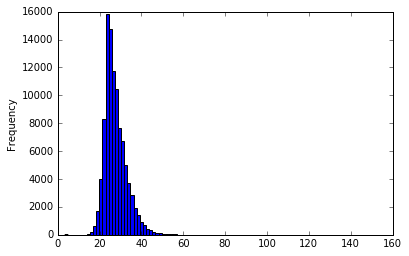

In [16]:
full_df.bmi.plot.hist(100)

#  Split back

In [17]:
train_df = full_df[~full_df.cardio.isnull()]
test_df = full_df[full_df.cardio.isnull()].drop('cardio', axis=1)

##  Model train

In [18]:
columns_with_nulls = test_df.columns[test_df.isnull().sum(axis=0) > 0]

In [19]:
X = train_df.drop(['id','cardio'], axis=1)
y = train_df.cardio

In [20]:
X_test = test_df.drop(['id'], axis=1)
X_test = X_test.fillna(-999)

In [21]:
models = []

np.random.seed(42)
for i in tqdm.tqdm_notebook(range(100)):
    X_train = X.copy()
    for col in columns_with_nulls:
        _idx = np.random.choice(X_train.index, size=X_train.shape[0]//10, replace=False)
        X_train.loc[_idx, col] = -999
    
    model = CatBoostClassifier(
        iterations=1000,
        depth=6,
        thread_count=12,
        border_count=128,
        learning_rate=0.015,
        random_seed=np.random.randint(10**10),
        logging_level='Silent'
    )
    
    model.fit(X_train, y)
    models.append(model.copy())

In [27]:
models2 = []

np.random.seed(42)
for i in tqdm.tqdm_notebook(range(10)):
    X_train = X.copy()
    for col in columns_with_nulls:
        _idx = np.random.choice(X_train.index, size=X_train.shape[0]//10, replace=False)
        X_train.loc[_idx, col] = -999
    
    model = lightgbm.LGBMClassifier(
        seed=np.random.randint(10**10),
        n_estimators=3680,
        max_depth=15 + np.random.randint(0,10),
        num_leaves=20 + np.random.randint(0,10),
        subsample=0.99868,
        colsample_bytree=0.8022,
        reg_alpha=26.4310,
        reg_lambda=19.7836,
        max_bin=8850,
        objective='binary',
        nthread=12
    )
    model.fit(X_train, y)
    models2.append(model)

In [22]:
predictions = []
for _model in tqdm.tqdm_notebook(models):
    predictions.append(_model.predict_proba(X_test)[:,1])
    
predictions = np.vstack(predictions).T

In [28]:
predictions2 = []
for _model in tqdm.tqdm_notebook(models2):
    predictions2.append(_model.predict_proba(X_test)[:,1])
    
predictions2 = np.vstack(predictions2).T

In [29]:
prediction = np.hstack([predictions, predictions2]).mean(axis=1)

In [30]:
pd.DataFrame(prediction).to_csv(
    'submission_{date}.csv'.format(
        date=datetime.today().strftime('%Y%m%d_%H%M')
    ),
    index=False, header=False
)